# Deep Reinforcement Learning in Action
### by Alex Zai and Brandon Brown

#### Chapter 3

##### Listing 3.1

In [1]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [ ]:
import sys

In [ ]:
game.display()

In [4]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('d')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', 'P']], dtype='<U2')

In [5]:
game.reward()

-1

In [6]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [7]:
game.board.render_np().shape

(4, 4, 4)

##### Listing 3.2

In [8]:
import numpy as np
import torch
from Gridworld import Gridworld
import random
from matplotlib import pylab as plt
 
l1 = 64
l2 = 150
l3 = 100
l4 = 4
 
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
 
gamma = 0.9
epsilon = 1.0

In [9]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

##### Listing 3.3

In [10]:
epochs = 1000
losses = []
for i in range(epochs):
    game = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    while(status == 1):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward() #-1 for lose, +1 for win, 0 otherwise
        with torch.no_grad():
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ)
        if reward == -1: # if game still in play
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach().squeeze()
        X = qval.squeeze()[action_]
        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: #game lost
            status = 0
    if epsilon > 0.1:
        epsilon -= (1/epochs)

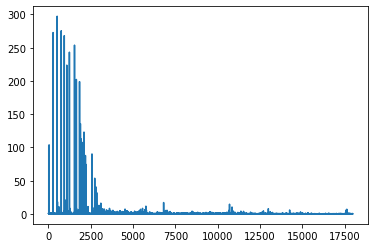

In [11]:
plt.plot(losses)

In [12]:
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
    y = m @ x + b
    return y
y = linear_model(torch.Tensor([4.]), m,b)

In [13]:
y

tensor([9.], grad_fn=<AddBackward0>)

In [14]:
y.grad_fn

In [15]:
with torch.no_grad():
    y = linear_model(torch.Tensor([4]),m,b)

In [16]:
y

tensor([9.])

In [17]:
y.grad_fn

In [18]:
y = linear_model(torch.Tensor([4.]), m,b)
y.backward()
m.grad

tensor([4.])

In [19]:
b.grad

tensor([1.])

##### Listing 3.4

In [20]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1: #if game is over
            if reward > 0: #if game won
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else: #game is lost
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    win = True if status == 2 else False
    return win

In [21]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

##### Listing 3.5

In [22]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model(state2_batch)
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0])
            X = \
            Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
 
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
losses = np.array(losses)

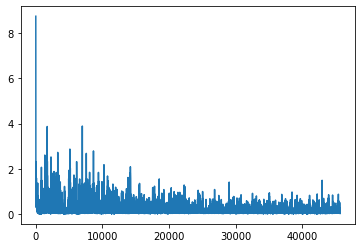

In [23]:
plt.plot(losses)

In [38]:
test_model(model,mode='random')

Initial State:
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']
 ['-' '+' ' ' ' ']]
Move #: 0; Taking action: r
[[' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']
 ['-' '+' ' ' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' 'W']
 ['-' '+' ' ' ' ']]
Move #: 2; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'P' ' ' 'W']
 ['-' '+' ' ' ' ']]
Move #: 3; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']
 ['-' '+' ' ' ' ']]
Game won! Reward: 10


True

##### Listing 3.6

In [45]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(100.0*win_perc))

Games played: 1000, # of wins: 908
Win percentage: 90.8


##### Listing 3.7

In [39]:
import copy
 
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
 
model2 = model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())
sync_freq = 50

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### Listing 3.8

In [41]:
from IPython.display import clear_output

In [42]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch)
            Y = reward_batch + gamma * ((1-done_batch) * \
            torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long() \
            .unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

4999 0.012652655132114887


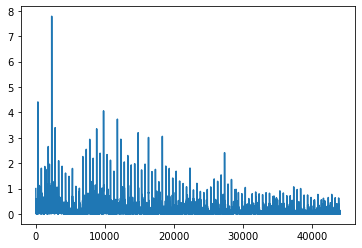

In [43]:
plt.plot(losses)

In [44]:
test_model(model,mode='random')

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']
 ['+' ' ' ' ' ' ']
 ['-' 'P' ' ' ' ']]
Move #: 0; Taking action: u
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']
 ['+' 'P' ' ' ' ']
 ['-' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']
 ['+' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']]
Game won! Reward: 10


True